# 13. 퀀트 전략을 이용한 종목선정 (심화)

지난 장에서는 팩터를 이용한 투자 전략의 기본이 되는 저변동성, 모멘텀, 밸류, 퀄리티 전략에 대해 알아보았습니다. 물론 이러한 단일 팩터를 이용한 투자도 장기적으로 우수한 성과를 보이지만, 여러 팩터를 결합하거나 정밀하게 전략을 만든다면 더욱 우수한 성과를 거둘 수 있습니다.

이번 장에서는 섹터별 효과를 없앤 후 포트폴리오를 구성하는 방법, 이상치 데이터 제거 및 팩터 결합 방법, 그리고 멀티팩터 구성 방법을 알아보겠습니다.

## 13.1 섹터 중립 포트폴리오

팩터 전략의 단점 중 하나는 선택된 종목들이 특정 섹터로 쏠리는 경우가 있다는 점입니다. 특히 과거 수익률을 토대로 종목을 선정하는 모멘텀 전략은 특정 섹터의 호황기에 동일한 섹터의 모든 종목이 함께 움직이는 경향이 있어 이러한 쏠림이 심할 수 있습니다.

먼저 지난 장에서 배운 12개월 모멘텀을 이용한 포트폴리오 구성 방법을 다시 살펴보겠습니다.

In [1]:
import pandas as pd
import numpy as np
from statistics import stdev 

KOR_ticker = pd.read_csv('data/KOR_ticker.csv', index_col=0)
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].astype(np.str).str.zfill(6)
KOR_price = pd.read_csv('data/KOR_price.csv', index_col = 0)

ret = KOR_price.pct_change()
ret_12m = ret.iloc[-252: ].apply(lambda x: (x+1).prod()-1)

invest_mom = (ret_12m.rank(ascending = False) <= 30).values

기존의 코드와 동일하게, 티커 및 주식 가격 데이터를 불러온 후 최근 12개월 수익률을 구해 상위 30종목을 선택합니다.

In [2]:
KOR_sector = pd.read_csv('data/KOR_sector.csv', index_col = 0)
KOR_sector['CMP_CD'] = KOR_sector['CMP_CD'].astype(np.str).str.zfill(6)

data_market = pd.merge(KOR_ticker, KOR_sector, left_on=['종목코드','종목명'], right_on = ['CMP_CD','CMP_KOR'], how='left')

해당 종목들의 섹터 정보를 추가로 살펴보기 위해, 섹터 데이터를 불러온 후 merge() 함수를 이용해 티커와 결합해 data_market에 저장합니다. 섹터별 종목수를 확인해보도록 하겠습니다.

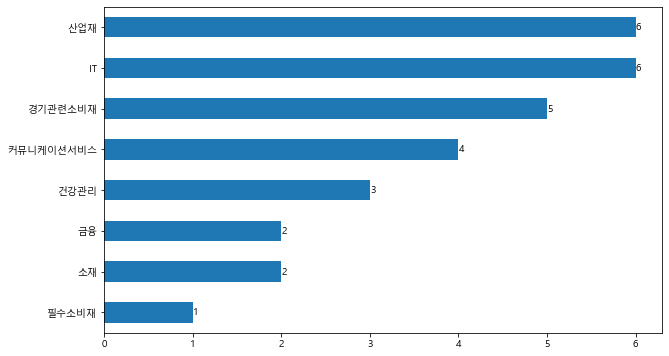

In [3]:
import matplotlib.pyplot as plt

mom_sector = pd.DataFrame(data_market[invest_mom]['SEC_NM_KOR'].value_counts())

plt.rc('font', family = 'Malgun Gothic')
mom_sector.plot.barh(figsize = (10, 6), legend = False)
plt.gca().invert_yaxis()

for y, x in enumerate(mom_sector['SEC_NM_KOR']):
    plt.annotate(str(x), xy=(x, y), va='center')

`value_counts()` 함수를 통해 섹터별 종목수를 계산해준 후 이를 그림으로 나타내보면, 특정 섹터에 대부분의 종목이 몰려 있음이 확인됩니다. 따라서 여러 종목으로 포트폴리오를 구성했지만, 이를 분해해보면 특정 섹터에 쏠림이 심하다는 것을 알 수 있습니다. 이러한 섹터 쏠림 현상을 제거한 **섹터 중립 포트폴리오**를 구성해보겠습니다.

In [4]:
data_market['ret'] = ret_12m.values
data_select = data_market[['종목코드', '종목명', 'SEC_NM_KOR', 'ret']]

sector_neutral = data_select.groupby('SEC_NM_KOR', dropna=False).ret.apply(lambda x: (x - x.mean())/x.std())

1. data_market의 ret 열에 미리 계산한 12개월 수익률 정보를 입력합니다.
1. data_market에서 종목코드, 종목명, 섹터 정보, 12개월 수익률을 선택합니다.
2. `groupby()` 함수를 통해 섹터별 그룹을 만들어 준 후, `apply()` 함수를 이용해 그룹별 수익률의 Z-Score를 구합니다. Z-Score는 $\frac{x-\mu}{\sigma}$로 계산됩니다.

위의 정규화 과정을 살펴보면, 전체 종목에서 12개월 수익률을 비교하는 것이 아닌 각 섹터별로 수익률의 강도를 비교하게 됩니다. 따라서 특정 종목의 과거 수익률이 전체 종목과 비교해서 높았더라도 해당 섹터 내에서의 순위가 낮다면, Z-Score 값은 낮아집니다.

따라서 섹터별 정규화 과정을 거친 값으로 비교 분석을 한다면, 섹터 효과가 제거된 포트폴리오를 구성할 수 있습니다.

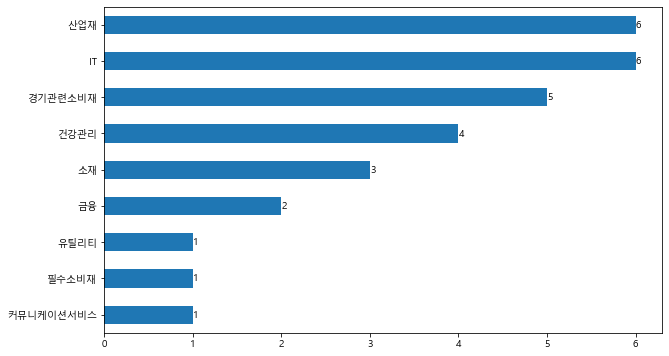

In [5]:
import matplotlib.pyplot as plt

invest_mom_neutral  = (sector_neutral.rank(ascending = False) <= 30).values
mom_sector_neutral = pd.DataFrame(data_market[invest_mom_neutral]['SEC_NM_KOR'].value_counts())

plt.rc('font', family = 'Malgun Gothic')
mom_sector_neutral.plot.barh(figsize = (10, 6), legend = False)
plt.gca().invert_yaxis()

for y, x in enumerate(mom_sector_neutral['SEC_NM_KOR']):
    plt.annotate(str(x), xy=(x, y), va='center')

정규화된 값의 랭킹이 높은 상위 30종목을 선택하며, 내림차순으로 계산합니다.. 해당 포트폴리오의 섹터별 구성종목을 확인해보면, 단순하게 포트폴리오를 구성한 것에 대비하여 여러 섹터에 종목이 분산되어 있습니다.

이처럼 `groupby()` 함수를 통해 손쉽게 그룹별 중립화를 할 수 있으며, 글로벌 투자를 하는 경우에는 지역, 국가, 섹터별로도 중립화된 포트폴리오를 구성하기도 합니다.

## 13.2 마법공식

하나의 팩터만을 보고 투자하는 것보다, 둘 혹은 그 이상의 팩터를 결합해 투자해야 훨씬 좋은 포트폴리오를 구성할 수 있으며, 이러한 방법을 멀티팩터라고 합니다. 그중에서도 밸류와 퀄리티의 조합은 전통적으로 많이 사용된 방법이며, 대표적인 예가 조엘 그린블라트의 마법공식입니다. 이에 앞서, 퀄리티와 밸류 간의 관계, 마법공식의 정의와 구성 방법을 알아보겠습니다.

### 13.2.1 퀄리티와 밸류 간의 관계

투자의 정석 중 하나는 **좋은 기업을 싸게 사는 것**입니다. 이를 팩터의 관점에서 이해하면 퀄리티 팩터와 밸류 팩터로 이해할 수도 있습니다.

여러 논문에 따르면 흔히 밸류 팩터와 퀄리티 팩터는 반대의 관계에 있습니다. 먼저 가치주들은 위험이 크기 때문에 시장에서 소외를 받아 저평가가 이루어지는 것이며, 이러한 위험에 대한 대가로 밸류 팩터의 수익률이 높게 됩니다. 반대로 사람들은 우량주에 기꺼이 프리미엄을 지불하려 하기 때문에 퀄리티 팩터의 수익률이 높기도 합니다. 이는 마치 동전의 양면과 같지만, 장기적으로 가치주와 우량주 모두 우수한 성과를 기록합니다. 먼저 퀄리티의 지표인 매출총이익과 밸류 지표인 PBR을 통해 둘 사이의 관계를 확인해 보겠습니다.

In [6]:
import pandas as pd
import numpy as np
import pickle
from datetime import date

KOR_ticker = pd.read_csv('data/KOR_ticker.csv', index_col=0)
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].astype(np.str).str.zfill(6)

KOR_value = pd.read_csv('data/KOR_value.csv', index_col=0)
KOR_value.index = KOR_value.index.astype(np.str).str.zfill(6)

with open('data/KOR_fs.pickle', 'rb') as f:
    KOR_fs = pickle.load(f)

# PBR
data_pbr = KOR_value.loc[:, 'PBR']    

# GPA
if date.today().month in(1,2,3,4):
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 2))
else:
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 1))
    
data_gpa = (KOR_fs['매출총이익'] / KOR_fs['자산']).iloc[:, num_col]    

# Bind & Rank
data_bind = pd.concat([data_pbr, data_gpa], axis = 1)
data_bind.columns = ['PBR', 'GPA']
data_bind_rank = pd.concat([data_bind['PBR'].rank(), data_bind['GPA'].rank(ascending = False)], axis = 1)

# correlation
data_bind_rank.corr()

,PBR,GPA
PBR,1.000000,-0.203685
GPA,-0.203685,1.000000


1. 티커와 밸류, 재무제표 데이터를 불러옵니다.
2. 밸류 데이터에서 PBR 지표만 선택합니다.
3. 재무제표 데이터에서 GPA(매출총이익/자산)을 구합니다.
4. 두 데이터를 합쳐준 후 PBR은 오름차순, GPA는 내림차순으로 랭킹을 구합니다.
5. 랭킹의 상관관계를 구합니다. 

PBR과 GPA 간에는 음의 상관관계가 있음이 확인됩니다. 이번에는 PBR의 분위수별 GPA 평균값을 구하겠습니다.

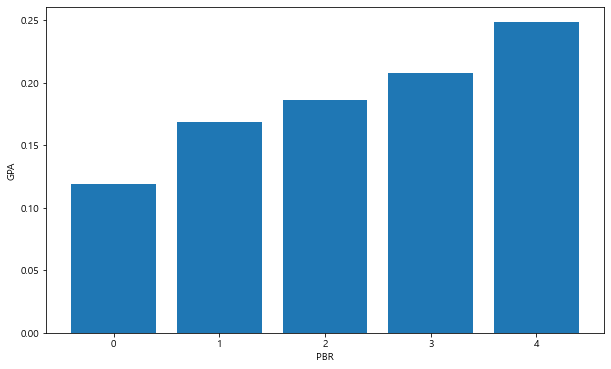

In [7]:
import matplotlib.pyplot as plt

data_bind['PBR_quantile'] = pd.qcut(data_bind['PBR'], q = 5, labels = range(1, 6))
data_bind_group = data_bind.dropna().groupby('PBR_quantile').mean('GPA')

fig, ax = plt.subplots(figsize=(10, 6))
plt.rc('font', family = 'Malgun Gothic')
plt.bar(x = np.arange(5), height = data_bind_group['GPA'])
plt.xlabel('PBR')
plt.ylabel('GPA')

plt.show()

1. `qcut()` 함수를 이용해 PBR을 5분위수로 나누어줍니다.
2. NA가 있는 데이터는 제외하며, `groupby()` 함수를 통해 PBR의 분위수별 그룹을 묶어줍니다. 그 후, 각 PBR 그룹별 GPA의 평균값을 구합니다.
3. 위 데이터를 그림으로 나타냅니다.

그림에서 알 수 있듯이 PBR이 낮을수록 GPA도 낮으며, 즉 가치주일수록 우량성은 떨어집니다. 반면에 PBR이 높을수록 GPA도 높으며, 이는 주식의 가격이 비쌀수록 우량성도 높다는 뜻입니다. 이를 이용해 밸류 팩터와 퀄리티 팩터 간의 관계를 나타내면 다음과 같습니다.

```{figure} image/tableqv.png
---
name: tableqv
---
밸류 팩터와 퀄리티 팩터간의 관계
```
주가가 쌀수록 기업의 우량성은 떨어지며(①번), 반대로 기업의 우량성이 좋으면 주식은 비싼 경향(③번)이 있습니다. 물론 우량성도 떨어지고 비싸기만한 주식(②번)을 사려는 사람들 아마 없을 겁니다. 결과적으로 우리가 원하는 최고의 주식은 우량성이 있으면서도 가격은 싼 주식(④번)입니다.

### 13.2.2 마법공식 이해하기

마법공식이란 고담 캐피탈의 설립자이자 전설적인 투자자 조엘 그린블라트에 의해 알려진 투자 방법입니다. 그는 본인의 책 《주식 시장을 이기는 작은 책》에서 투자를 하는데 있어 중요한 두 가지 지표가 있으며, 이를 혼합하면 뛰어난 성과를 기록할 수 있다고 했습니다.
 
첫 번째 지표는 **이율(Earnings Yield)** 로서 기업의 수익을 기업의 가치로 나는 값입니다. 이는 PER의 역수와 비슷하며, 밸류 지표 중 하나입니다. 두 번째 지표는 **투하자본 수익률(Return on Capital)** 로서 기업의 수익을 투자한 자본으로 나눈 값입니다. 이는 ROE와도 비슷하며, 퀄리티 지표 중 하나입니다. 마법공식은 이 두 가지 지표의 랭킹을 각각 구한 후 랭킹의 합 기준 상위 30개 종목을 1년간 보유한 후 매도하는 전략입니다.

해당 전략은 국내 투자자들에게도 많이 사랑받는 전략이지만 두 지표를 계산하기 위한 데이터를 수집하기 어려워 많은 투자자들이 이율 대신 PER를 사용하고, 투하자본 수익률 대신 ROE를 사용합니다. 그러나 우리가 수집한 데이터를 통해 충분히 원래의 마법공식을 구현할 수 있습니다.

```{table} 마법공식의 구성 요소
:name: magic_formula

| 팩터 | Value | Quality |
|----|----|----|
| 지표 | 이율 (Earnings Yield) | 투하자본 수익률 (Return On Capital) |
| 계산 | $\frac{이자\ 및\ 법인세\ 차감전이익}{기업\ 가치}$ | $\frac{이자\ 및\ 법인세\ 차감전이익}{투하\ 자본}$|
```

### 13.2.3 마법공식 구성하기

재무제표 항목을 통해 이율과 투하자본 수익률을 계산하고, 이를 통해 마법공식 포트폴리오를 구성하겠습니다. 먼저 밸류 지표에 해당하는 이익수익률을 계산해보겠습니다. 이익수익률은 이자 및 법인세 차감전이익(EBIT)을 기업가치(시가총액 + 순차입금)로 나눈 값입니다. 이를 분해하면 다음과 같습니다.

$$ \begin{align} 이익수익률 &= \frac{이자\ 및\ 법인세\ 차감전이익}{기업\ 가치} \\ &= \frac{이자\ 및\ 법인세\ 차감전이익}{시가총액 + 순차입금} 
\\ &= \frac{당기순이익 + 법인세 + 이자비용}{시가총액 + 총부채 - 여유자금}
\\ &= \frac{당기순이익 + 법인세 + 이자비용}{시가총액 + 총부채 - (현금 - max(0, 유동부채 - 유동자산 + 현금))} \end{align} $$

In [8]:
import pandas as pd
import numpy as np
import pickle
from datetime import date

KOR_ticker = pd.read_csv('data/KOR_ticker.csv', index_col=0)
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].astype(np.str).str.zfill(6)

KOR_value = pd.read_csv('data/KOR_value.csv', index_col=0)
KOR_value.index = KOR_value.index.astype(np.str).str.zfill(6)

with open('data/KOR_fs.pickle', 'rb') as f:
    KOR_fs = pickle.load(f)
    
if date.today().month in(1,2,3):
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 2))
else:
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 1))
    
# 분자
magic_ebit = (KOR_fs['지배주주순이익'] + KOR_fs['법인세비용'] + KOR_fs['이자비용']).iloc[:, num_col]    

# 분모
magic_cap = KOR_value['PER'] * KOR_fs['지배주주순이익'].iloc[:, num_col]
magic_debt = KOR_fs['부채'].iloc[:, num_col]
magic_excess_cash_1  = (KOR_fs['유동부채'] - KOR_fs['유동자산'] + KOR_fs['현금및현금성자산']).iloc[:, num_col]
magic_excess_cash_1[magic_excess_cash_1<0] = 0
magic_excess_cash_2  = KOR_fs['현금및현금성자산'].iloc[:, num_col] - magic_excess_cash_1
magic_ev  = magic_cap + magic_debt - magic_excess_cash_2

# 이익수익률
magic_ey = magic_ebit / magic_ev

가치지표, 재무제표, 티커 데이터를 불러온 후 재무제표 열 개수를 구합니다. 그후 분자와 분모 항목에 해당하는 부분을 하나씩 계산합니다. 먼저 분자 부분인 이자및 법인세 차감전이익은 지배주주 순이익에 법인세비용과 이자비용을 더해준 후 최근년도 데이터를 선택합니다.

분모 부분은 시가총액, 총 부채, 여유자금 총 세 가지로 구성되어 있습니다.

1. 우리가 가지고 있는 밸류 데이터와 재무제표 데이터를 통해 시가총액을 역산할 수 있습니다. PER 값에 Earnings를 곱해주면 시가총액이 계산됩니다. 이를 통해 계산된 시가총액을 HTS나 금융 웹사이트의 값과 비교하면 거의 비슷함이 확인됩니다.

$$ \begin{align}
PER \times Earnings & = \frac{Price}{Earnings/Shares} \times Earnings \\
& = \frac{Price \times Shares}{Earnings} \times Earnings \\
& = Price \times Shares = Market\,Cap
\end{align} $$

2. 총 부채는 부채 항목을 사용합니다.
3. 여유자금은 두 단계에 걸쳐 계산합니다. 먼저 **유동부채 - 유동자산 + 현금** 값을 구해준 후 0보다 작은 값은 모두 0으로 바꿔줍니다. 이 값을 현금 및 현금성자산 항목에서 차감해 최종적인 여유자금을 구합니다.

분자와 분모 부분을 나누어주면 이익수익률을 계산할 수 있습니다.

다음으로 퀄리티 지표에 해당하는 투하자본 수익률을 계산하겠습니다. 해당 값은 이자 및 법인세 차감전이익(EBIT)를 투하자본(IC)으로 나누어 계산되며, 이를 분해하면 다음과 같습니다.

$$ \begin{align}
투하자본\ 수익률 & = \frac{이자\ 및\ 법인세\ 차감전이익}{투하자본} \\
& = \frac{당기순이익 + 법인세 + 이자비용}{(유동자산 - 유동부채) + (비유동자산 - 감가상각비)}
\end{align} $$

In [9]:
magic_ic = ((KOR_fs['유동자산'] - KOR_fs['유동부채']) + (KOR_fs['비유동자산'] - KOR_fs['감가상각비'])).iloc[:, num_col]
magic_roc = magic_ebit / magic_ic

투하자본 수익률은 비교적 쉽게 계산할 수 있습니다. 분모에 해당하는 투하자본의 경우 재무제표 항목을 그대로 사용하면 되며, 분자인 이자 및 법인세 차감전이익은 위에서 이미 구해둔 값을 사용하면 됩니다.

이제 두 지표를 활용해 마법공식 포트폴리오를 구성하겠습니다.

In [10]:
invest_magic = (magic_ey.rank(ascending = False) + magic_roc.rank(ascending = False)).rank() <= 30

invest_magic_df = KOR_ticker.loc[invest_magic.values, ['종목코드', '종목명']]
invest_magic_df['이익수익률'] = magic_ey[invest_magic].values.round(3)
invest_magic_df['투하자본수익률'] = magic_roc[invest_magic].values.round(3)

invest_magic_df

,종목코드,종목명,이익수익률,투하자본수익률
68,096530,씨젠,0.139,0.951
282,036830,솔브레인홀딩스,1.251,1.282
413,024720,한국콜마홀딩스,0.217,0.246
416,033290,코웰패션,0.131,0.272
440,206640,바디텍메드,0.109,0.461
456,068290,삼성출판사,0.121,0.357
472,009410,태영건설,0.195,0.355
477,064550,바이오니아,0.116,0.370
498,035890,서희건설,0.185,0.276
518,034810,해성산업,0.369,0.369


이익수익률과 투하자본 수익률의 랭킹을 내림차순으로 각각 구해주며, 두 값의 합의 랭킹 기준 상위 30종목을 선택한 후 종목코드, 종목명과 각 지표를 확인합니다. 마법공식을 통해 선택된 종목은 상대적으로 퀄리티와 밸류가 우수한 종목이라 볼 수 있습니다.

## 13.3 이상치 데이터 제거 및 팩터의 결합

모든 데이터 분석에서 중요한 문제 중 하나가 이상치(극단치, Outlier) 데이터를 어떻게 처리할 것인가입니다. 과거 12개월 수익률이 10배인 주식이 과연 모멘텀 관점에서 좋기만 한 주식인지, ROE가 100% 넘는 주식이 과연 퀄리티 관점에서 좋기만 한 주식인지 고민이 되기 마련입니다.

따라서 이러한 이상치를 제외하고 분석할지, 포함해서 분석할지를 판단해야 합니다. 만일 이상치를 포함한다면 그대로 사용할 것인지, 보정해 사용할 것인지도 판단해야 합니다.

우리가 가지고 있는 데이터에서 이상치 데이터를 탐색해보겠습니다.

In [30]:
import pandas as pd

KOR_value = pd.read_csv('data/KOR_value.csv', index_col=0)
PBR_max = KOR_value['PBR'].max()

print(PBR_max)

64.08200046969698


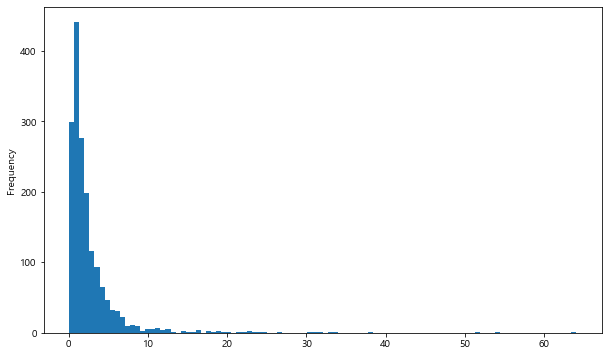

In [31]:
KOR_value['PBR'].plot.hist(bins = 100, figsize = (10, 6))
plt.show()

국내 종목들의 PBR 히스토그램을 그려보면 오른쪽으로 꼬리가 매우 긴 분포를 보이고 있습니다. 이는 PBR이 무려 수백대인 이상치 데이터가 있기 때문입니다. 이처럼 모든 팩터 지표에는 극단치 데이터가 있기 마련이며, 이를 처리하는 방법을 알아보겠습니다.

### 10.3.1 트림(Trim): 이상치 데이터 삭제

트림은 이상치 데이터를 삭제하는 방법입니다. 위의 예제에서 이상치에 해당하는 상하위 1% 데이터를 삭제하겠습니다.

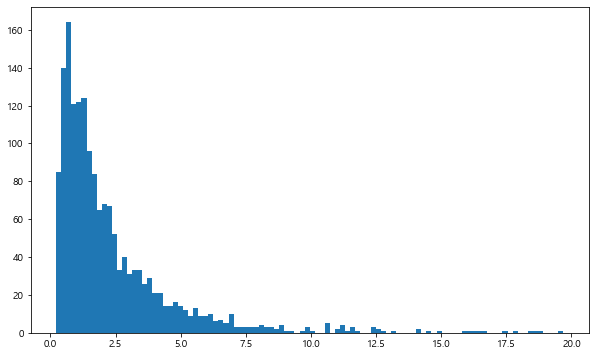

In [13]:
q_low = KOR_value['PBR'].quantile(0.01)
q_hi  = KOR_value['PBR'].quantile(0.99)

value_trim = KOR_value.loc[(KOR_value["PBR"] > q_low) & (KOR_value["PBR"] < q_hi), ['PBR']]

fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = plt.hist(value_trim, bins=100)

`quantile()` 함수를 통해 백분위를 구한 후 상하위 1%에 해당하는 데이터를 제외한 데이터만 선택했습니다. 결과적으로 지나치게 PBR이 낮은 종목과 높은 종목은 제거되어 x축의 스케일이 많이 줄어든 모습입니다.

평균이나 분산같이 통곗값을 구하는 과정에서는 이상치 데이터를 제거하는 것이 바람직할 수 있습니다. 그러나 팩터를 이용해 포트폴리오를 구하는 과정에서 해당 방법은 조심스럽게 사용되어야 합니다. 데이터의 손실이 발생하게 되며, 제거된 종목 중 정말로 좋은 종목이 있을 수도 있기 때문입니다.

### 13.3.2 윈저라이징(Winsorizing): 이상치 데이터 대체

포트폴리오 구성에서는 일반적으로 이상치 데이터를 다른 데이터로 대체하는 윈저라이징 방법이 사용됩니다. 예를 들어 상위 1%를 초과하는 데이터는 1% 값으로 대체하며, 하위 1% 미만의 데이터는 1% 데이터로 대체합니다. 즉, 좌우로 울타리를 쳐놓고 해당 범위를 넘어가는 값을 강제로 울타리에 맞춰줍니다.

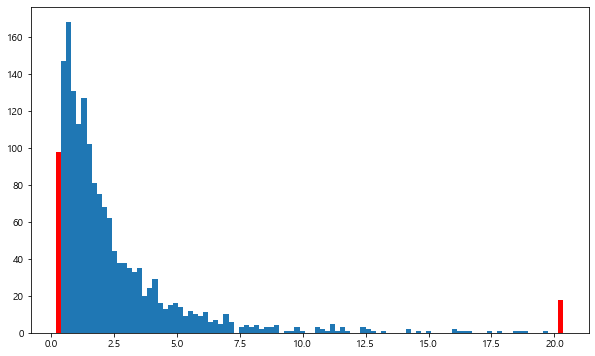

In [14]:
value_winsor = KOR_value[['PBR']].copy()
value_winsor.loc[value_winsor["PBR"] < q_low , 'PBR'] = q_low
value_winsor.loc[value_winsor["PBR"] > q_hi , 'PBR'] = q_hi

fig, ax = plt.subplots(figsize=(10, 6))
n, bins, patches  = plt.hist(value_winsor, bins=100)
patches[0].set_fc('red')
patches[-1].set_fc('red')

먼저 PBR 데이터를 카피해준 후, 상하위 1%를 초과하는 값들은 해당 기준으로 변경해줍니다. 그림을 살펴보면 x축 양 끝부분의 막대가 길어진 것으 확인할 수 있습니다. 

### 13.3.3 팩터의 결합 방법

밸류 지표의 결합, 퀄리티 지표의 결합, 마법공식 포트폴리오를 구성할 때 단순히 랭킹을 더하는 방법을 사용했습니다. 물론 투자 종목수가 얼마 되지 않거나, 개인 투자자의 입장에서는 이러한 방법이 가장 단순하면서도 효과적일수 있습니다. 그러나 전문투자자의 입장이거나 팩터를 분석하는 업무를 할 경우 이처럼 단순히 랭킹을 더하는 방법은 여러 가지 문제를 안고 있습니다.

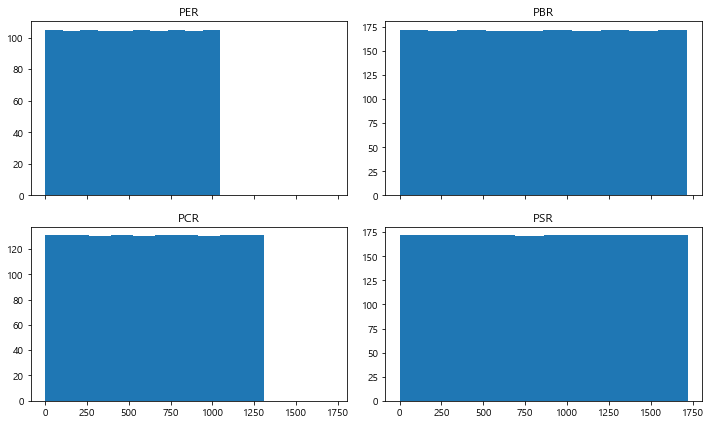

In [15]:
value_rank = KOR_value.rank(axis = 0)

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
for n, ax in enumerate(axes.flatten()):
    ax.hist(value_rank.iloc[:, n])                   
    ax.set_title(value_rank.columns[n], size = 12)

fig.tight_layout() 

앞의 그림은 각 밸류 지표의 랭킹을 구한 후 히스토그램으로 나타낸 것입니다. 랭킹을 구하는 것의 가장 큰 장점은 극단치로 인한 효과가 사라진다는 점과 균등한 분포를 가진다는 점입니다.

그러나 각 지표의 x축을 보면 최댓값이 서로 다릅니다. 이는 지표별 결측치로 인해 유효 데이터의 개수가 달라 나타나는 현상이며, 서로 다른 범위의 분포를 단순히 합치는 것은 좋은 방법이 아닙니다. 예를 들어 A, B, C, D 팩터에 각각 비중을 40%, 30%, 20%, 10% 부여해 포트폴리오를 구성한다고 가정해봅시다. 각 랭킹은 분포의 범위가 다르므로, 랭킹과 비중의 가중평균을 통해 포트폴리오를 구성하면 왜곡된 결과를 발생시킵니다.

이러한 문제를 해결하는 가장 좋은 방법은 랭킹을 구한 후 이를 Z-Score로 정규화하는 것입니다.

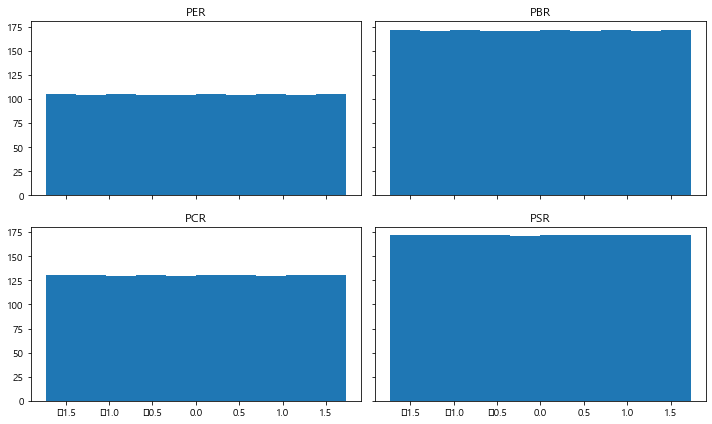

In [33]:
plt.rc('font', family = 'Malgun Gothic')

from scipy.stats import zscore

value_rank = KOR_value.rank(axis = 0)
value_rank_z = value_rank.apply(zscore, nan_policy='omit')

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey = True)
for n, ax in enumerate(axes.flatten()):
    ax.hist(value_rank_z.iloc[:, n])                   
    ax.set_title(value_rank.columns[n], size = 12)

fig.tight_layout() 

`rank()` 함수를 통해 랭킹을 구한 후, `apply(zscore)` 함수를 통해 정규화를 해주었습니다. 기본적으로 랭킹의 분포가 가진 극단치 효과가 사라지는 점과 균등 분포의 장점을 유지하고 있으며, 분포의 범위 역시 거의 동일하게 바뀌었습니다.

이처럼 여러 팩터를 결합해 포트폴리오를 구성하고자 하는 경우, 먼저 각 팩터(지표)별 랭킹을 정규화한 뒤 더해야 왜곡 효과가 제거되어 안정적입니다.

$$Z - Score(Rank(Factor\ A)) + Z - Score(Rank(Factor\ B)) +\dots + Z - Score(Rank(Factor\ N))$$

## 13.4 멀티팩터 포트폴리오

앞에서 배웠던 팩터 이론들과 결합 방법들을 응용해 멀티팩터 포트폴리오를 구성해보겠습니다. 각 팩터에 사용되는 지표는 다음과 같습니다.

- 퀄리티: 자기자본이익률, 매출총이익, 영업활동현금흐름
- 밸류: PER, PBR, PSR, PCR
- 모멘텀: 3개월 수익률, 6개월 수익률, 12개월 수익률

In [17]:
import pandas as pd
import numpy as np
from statistics import stdev 
import pickle
from datetime import date
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

KOR_ticker = pd.read_csv('data/KOR_ticker.csv', index_col=0)
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].astype(np.str).str.zfill(6)

KOR_value = pd.read_csv('data/KOR_value.csv', index_col=0)
KOR_value.index = KOR_value.index.astype(np.str).str.zfill(6)

KOR_price = pd.read_csv('data/KOR_price.csv', index_col = 0)
with open('data/KOR_fs.pickle', 'rb') as f:
    KOR_fs = pickle.load(f)

먼저 재무제표, 가치지표, 주가 데이터를 불러옵니다.

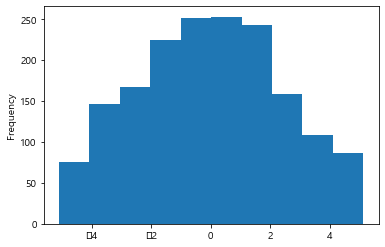

In [35]:
if date.today().month in(1,2,3):
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 2))
else:
    num_col = KOR_fs['매출액'].columns.str[0:4].get_loc(str(date.today().year - 1))
    
q_roe = (KOR_fs['지배주주순이익'] / KOR_fs['자본']).iloc[:, num_col]
q_gpa = (KOR_fs['매출총이익'] / KOR_fs['자산']).iloc[:, num_col]
q_cfo = (KOR_fs['영업활동으로인한현금흐름'] / KOR_fs['자산']).iloc[:, num_col]

q_profit = pd.concat([q_roe, q_gpa, q_cfo], axis = 1)
q_profit.columns = ['ROE', 'GPA', 'CFO']    

factor_quality = q_profit.rank(ascending = False, axis = 0).apply(zscore, nan_policy='omit').sum(axis = 1, skipna=False)

factor_quality.plot.hist()
plt.show()

첫 번째로 퀄리티 지표를 계산해줍니다. 먼저 자기자본이익률, 매출총이익, 영업활동현금흐름을 계산해줍니다. 지표를 하나의 데이터프레임으로 합친 후, 각 지표별 랭킹을 구합니다. 그 후 표준화를 위해 Z-Score를 계산한 후 종목별로 합쳐줍니다. Z-Score의 히스토그램을 살펴보면 이상치가 없이 중앙에 데이터가 많이 분포되어 있습니다.

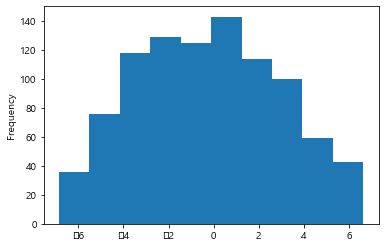

In [36]:
factor_value = KOR_value.rank(axis = 0).apply(zscore, nan_policy='omit').sum(axis = 1, skipna=False)

factor_value.plot.hist()
plt.show()

두 번째로 밸류 지표를 계산해줍니다. 밸류 지표는 이미 테이블 형태로 들어와 있으며, 랭킹과 표준화를 거쳐 합을 구해줍니다. 역시나 이상치가 없이 중앙에 데이터가 많이 분포되어 있습니다.

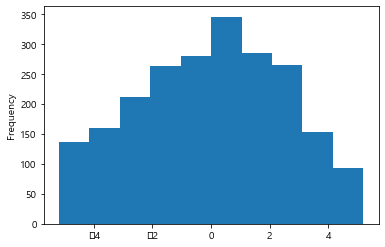

In [20]:
ret = KOR_price.pct_change()

ret_3m = ret.iloc[-60: ].apply(lambda x: (x+1).prod()-1)
ret_6m = ret.iloc[-120: ].apply(lambda x: (x+1).prod()-1)
ret_12m = ret.iloc[-252: ].apply(lambda x: (x+1).prod()-1)

ret_bind = pd.concat([ret_3m, ret_6m, ret_12m], axis = 1)
ret_bind.columns = ['3M', '6M', '12M']
factor_mom = ret_bind.rank(ascending = False, axis = 0).apply(zscore, nan_policy='omit').sum(axis = 1, skipna=False)

factor_mom.plot.hist()
plt.show()

마지막으로 모멘텀 지표를 계산해줍니다. 최근 60일, 120일, 252일 주가를 통해 3개월, 6개월, 12개월 수익률을 구해준 후 하나의 데이터프레임으로 묶어줍니다. 그 후 내림차순 기준 랭킹과 표준화를 거쳐 합을 구합니다.

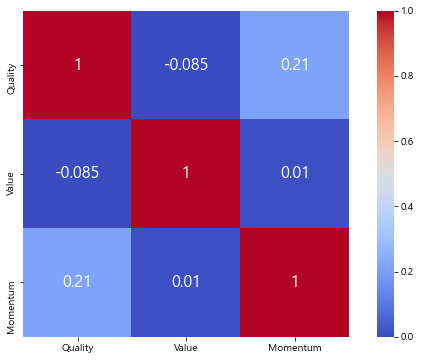

In [21]:
factor_bind = pd.concat([factor_quality, factor_value, factor_mom], axis = 1)
factor_bind.columns = ['Quality', 'Value', 'Momentum']

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(factor_bind.corr(), annot = True, annot_kws = {"size" : 16},
            vmin=0, vmax=1, center= 0.5, cmap= 'coolwarm', square = True)
plt.show()

퀄리티, 밸류, 모멘텀 팩터 간의 랭크의 서로 간 상관관계가 매우 낮으며, 여러 팩터를 동시에 고려함으로서 분산효과를 기대할 수 있습니다.

In [22]:
factor_allocation = [0.33, 0.33, 0.33]

factor_qvm = (factor_bind.apply(zscore, nan_policy='omit') * factor_allocation).sum(axis = 1, skipna=False)
invest_qvm = (factor_qvm.rank() <= 30).values

계산된 팩터들을 토대로 최종 포트폴리오를 구성해보겠습니다. 각 팩터의 분포가 역시나 다르기 때문에 다시 한번 Z-Score로 정규화해주며, 각 팩터에 동일한 비중인 0.33을 곱한 후 이를 더합니다. 물론 팩터별 비중을 [0.2, 0.4, 0.4]와 같이 다르게 줄 수도 있으며, 이는 어떠한 팩터를 더욱 중요하게 생각하는지 혹은 더욱 좋게 보는지에 따라 조정이 가능합니다. 최종적으로 해당 값의 랭킹 기준 상위 30종목을 선택합니다.

선택된 종목들의 분포를 확인해보기 이전에, 이상치 데이터로 인해 히스토그램이 잘 보이지 않는 문제 해결을 위해 앞서 이상치 데이터를 삭제하는(트림) 함수를 만들도록 하겠습니다.

In [23]:
def remove_outlier(df, cutoff = 0.01):
    q_low = df.quantile(cutoff)
    q_hi = df.quantile(1 - cutoff)
    
    df_trim = df.loc[(df > q_low) & (df < q_hi)]
    
    return(df_trim)

상하위 cutoff에 해당하는 데이터는 삭제해주도록 합니다. 이제 멀티팩터 기준 선정된 포트폴리오가 퀄리티, 밸류, 모멘텀 기준 어느 정도에 위치해 있는지 확인해보도록 하겠습니다.

C:\Users\leebi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\leebi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


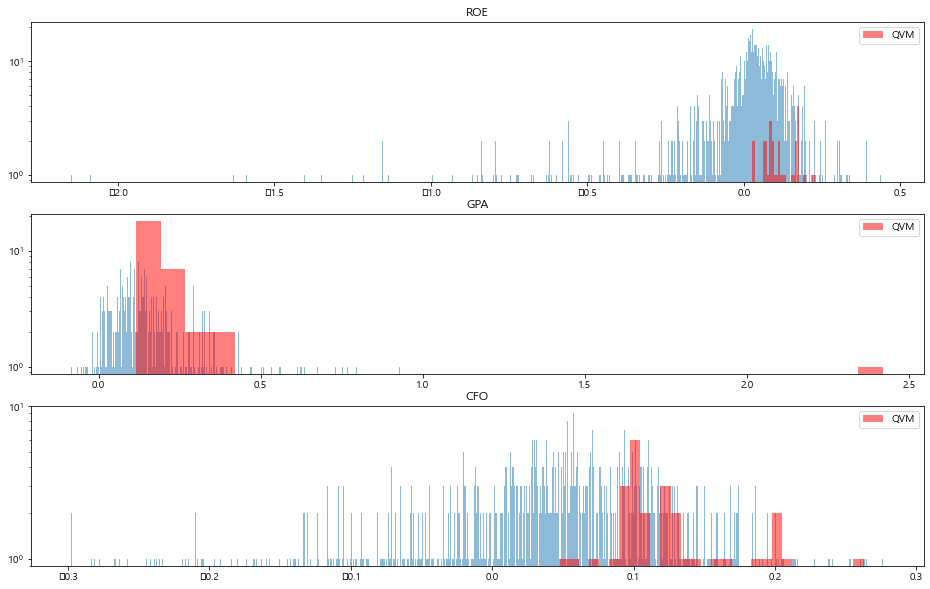

In [24]:
data = q_profit
n = len(data.columns)
fig = plt.subplots(figsize = (16, 10) )

for i in range(n):  
    
    plt.subplot(n, 1, i+1)

    df = data.iloc[:, i]
    df_mod = remove_outlier(df)    
    l = len(df_mod)
    
    plt.hist(df_mod,  bins = l, alpha = 0.5)             
    plt.hist(df.iloc[invest_qvm], bins = 30, color = 'r', alpha = 0.5, label = 'QVM')
    plt.yscale('log')
    plt.legend(loc="upper right")
    plt.gca().title.set_text(data.columns[i])    

plt.show()    

파란색은 전종목의 각 퀄리티 지표 별 히스토그램이며, 붉은색은 선택된 종목의 퀄리티 지표 별 히스토그램입니다. $y$축은 비교의 편의를 위해 로그로 치환했습니다. 대부분 종목의 퀄리티가 상위권에 위치하고 있음이 확인됩니다.

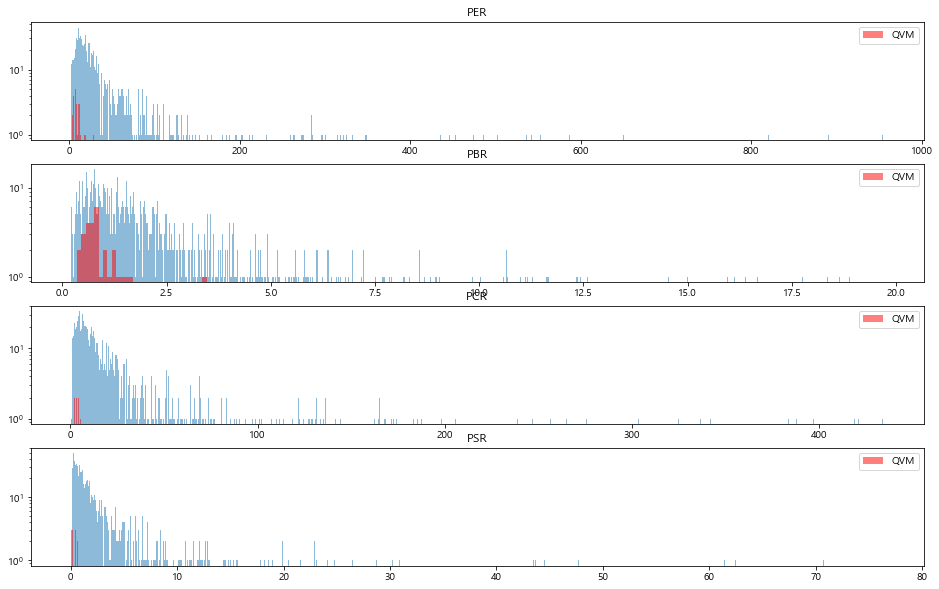

In [25]:
data = KOR_value
n = len(data.columns)
fig = plt.subplots(figsize = (16, 10) )

for i in range(n):  
    
    plt.subplot(n, 1, i+1)

    df = data.iloc[:, i]
    df_mod = remove_outlier(df)    
    l = len(df_mod)
    
    plt.hist(df_mod,  bins = l, alpha = 0.5)             
    plt.hist(df.iloc[invest_qvm], bins = 30, color = 'r', alpha = 0.5, label = 'QVM')
    plt.yscale('log')
    plt.legend(loc="upper right")
    plt.gca().title.set_text(data.columns[i])    

plt.show()    

이번에는 밸류 지표의 분포입니다. 대부분 종목이 좌측에 분포하여 밸류가 낮음이 확인됩니다.

C:\Users\leebi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\leebi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


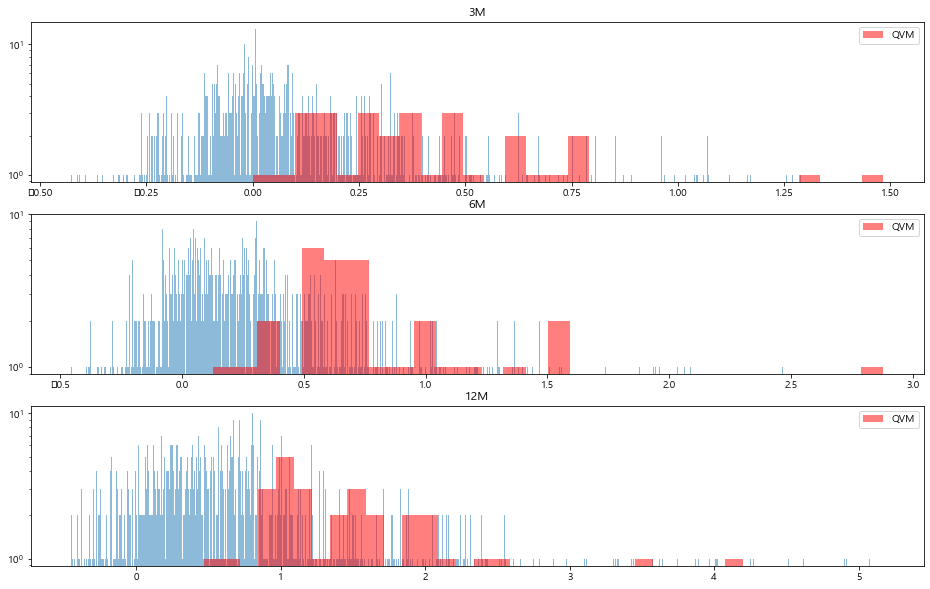

In [26]:
data = ret_bind
n = len(data.columns)
fig = plt.subplots(figsize = (16, 10) )

for i in range(n):  
    
    plt.subplot(n, 1, i+1)

    df = data.iloc[:, i]
    df_mod = remove_outlier(df) 
    df_mod = df_mod[df_mod != 0]
    l = len(df_mod)
    
    plt.hist(df_mod,  bins = l, alpha = 0.5)             
    plt.hist(df.iloc[invest_qvm], bins = 30, color = 'r', alpha = 0.5, label = 'QVM')
    plt.yscale('log')
    plt.legend(loc="upper right")
    plt.gca().title.set_text(data.columns[i])    

plt.show()    

마지막으로 모멘텀 지표의 분포에서는 거래정지로 인해 수익률이 0인 데이터 제외해줍니다. 역시나 대부분의 종목들이 우측에 분포하여 최근 수익률이 높은 종목임이 확인됩니다.

In [27]:
from functools import reduce

invest_qvm_df = KOR_ticker[invest_qvm][['종목코드', '종목명']].set_index('종목코드')
df_list = [invest_qvm_df, # 티커
           q_profit[invest_qvm].round(2), # 퀄리티
           KOR_value[invest_qvm].round(2), # 밸류
           ret_bind[invest_qvm].round(2)] # 모멘텀

df = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how='inner'), df_list)

df

,종목명,ROE,GPA,CFO,PER,PBR,PCR,PSR,3M,6M,12M
066570,LG전자,0.11,0.34,0.10,13.09,1.47,5.57,0.41,0.14,0.76,2.13
298020,효성티앤씨,0.19,0.18,0.20,18.10,3.46,4.38,0.48,1.29,2.88,4.20
120110,코오롱인더,0.09,0.21,0.10,8.22,0.73,3.35,0.41,0.45,0.65,1.11
001120,LG상사,0.17,0.14,0.05,4.00,0.68,4.68,0.11,0.17,1.02,1.63
014830,유니드,0.10,0.18,0.14,8.02,0.79,3.91,0.69,0.43,0.55,1.00
003070,코오롱글로벌,0.17,0.17,0.12,6.52,1.11,1.78,0.14,0.12,0.13,1.99
035890,서희건설,0.23,0.19,0.19,3.51,0.81,1.85,0.34,0.13,0.58,1.05
084010,대한제강,0.09,0.14,0.21,8.98,0.80,2.21,0.40,0.62,1.55,2.52
002310,아세아제지,0.09,0.17,0.12,8.66,0.74,4.43,0.64,0.35,0.72,0.90
002020,코오롱,0.17,0.16,0.09,2.74,0.48,1.23,0.08,0.47,0.56,1.58


포트폴리오 내 종목들을 대상으로 팩터별 지표를 나타냈습니다. 전반적으로 퀄리티는 높고 밸류는 낮으며, 모멘텀은 높은 모습을 보입니다. 물론 특정 팩터의 강도가 약하더라도 나머지 팩터의 강도가 충분히 강하다면, 포트폴리오에 편입되는 모습을 보이기도 합니다.

In [28]:
df.median()

ROE    0.110
GPA    0.180
CFO    0.115
PER    7.885
PBR    0.800
PCR    3.450
PSR    0.320
3M     0.365
6M     0.685
12M    1.410
dtype: float64

마지막으로 포트폴리오 내 종목들의 지표별 평균을 확인해 봅니다.